In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras import layers
from keras import models

import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
# EXAMPLE
aux = [[[1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5]]]

np.pad(aux, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 2, 2, 2, 2, 2, 0, 0],
        [0, 0, 3, 3, 3, 3, 3, 0, 0],
        [0, 0, 4, 4, 4, 4, 4, 0, 0],
        [0, 0, 5, 5, 5, 5, 5, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]])

In [5]:
def preprocess(imgs):
    imgs = imgs.astype('float32') / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, axis=-1)
    return imgs

In [6]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)
x_train.shape, x_test.shape

((60000, 32, 32, 1), (10000, 32, 32, 1))

## Creating the Encoder

- Image to Vector

In [7]:
encoder_input = layers.Input(
    shape=(32, 32, 1),
    name='encoder_input'
)

x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=2,
    padding='same',
    activation='relu'
)(encoder_input)

x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=2,
    padding='same',
    activation='relu'
)(x)

x = layers.Conv2D(
    filters=128,
    kernel_size=3,
    strides=2,
    padding='same',
    activation='relu'
)(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)

x = layers.Flatten()(x)

encoder_output = layers.Dense(
    units=2,
    name='encoder_output'
)(x)

encoder = models.Model(
    encoder_input,
    encoder_output
)

(None, 4, 4, 128)


## Creating the Decoder

- Vector to Image

In [8]:
shape_before_flattening[1:]

(4, 4, 128)

In [9]:
decoder_input = layers.Input(
    shape=(2,),
    name='decoder_input'
)

x = layers.Dense(np.prod(shape_before_flattening[1:]))(decoder_input)
print(x)

x = layers.Reshape(shape_before_flattening[1:])(x)
print(x.shape)

x = layers.Conv2DTranspose(
    filters=128,
    kernel_size=3,
    strides=2,
    padding='same',
    activation='relu'
)(x)

x = layers.Conv2DTranspose(
    filters=64,
    kernel_size=3,
    strides=2,
    padding='same',
    activation='relu'
)(x)

x = layers.Conv2DTranspose(
    filters=32,
    kernel_size=3,
    strides=2,
    padding='same',
    activation='relu'
)(x)

decoder_output = layers.Conv2D(
    filters=1,
    kernel_size=3,
    padding='same',
    activation='sigmoid',
    name='decoder_output'
)(x)

decoder = models.Model(
    decoder_input,
    decoder_output
)

KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")
(None, 4, 4, 128)


## Autoencoder

- A model that takes an image and passes it through the encoder and back out through the decoder to generate a reconstruction of the original image

In [10]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))

## Compiling

In [11]:
autoencoder.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

## Training

- Since the model is expected to receive images and return the same reconstructed image, the model will be trained by passing in the input images as both the input and output

In [12]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=3,
    batch_size=100,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/5
600/600 [==============================] - 229s 378ms/step - loss: 0.2905 - val_loss: 0.2608
Epoch 2/5
600/600 [==============================] - 217s 361ms/step - loss: 0.2573 - val_loss: 0.2571
Epoch 3/5
600/600 [==============================] - 225s 375ms/step - loss: 0.2541 - val_loss: 0.2542
Epoch 4/5
600/600 [==============================] - 217s 362ms/step - loss: 0.2521 - val_loss: 0.2524
Epoch 5/5
600/600 [==============================] - 232s 387ms/step - loss: 0.2507 - val_loss: 0.2519


## Reconstructing Images

In [13]:
example_images = x_test[:5000]
predictions = autoencoder.predict(example_images)

157/157 [==============================] - 11s 64ms/step


## Visualizing the Latent Space

- Latent space is a lower-dimensional space that captures the essential features of the input data

157/157 [==============================] - 1s 6ms/step


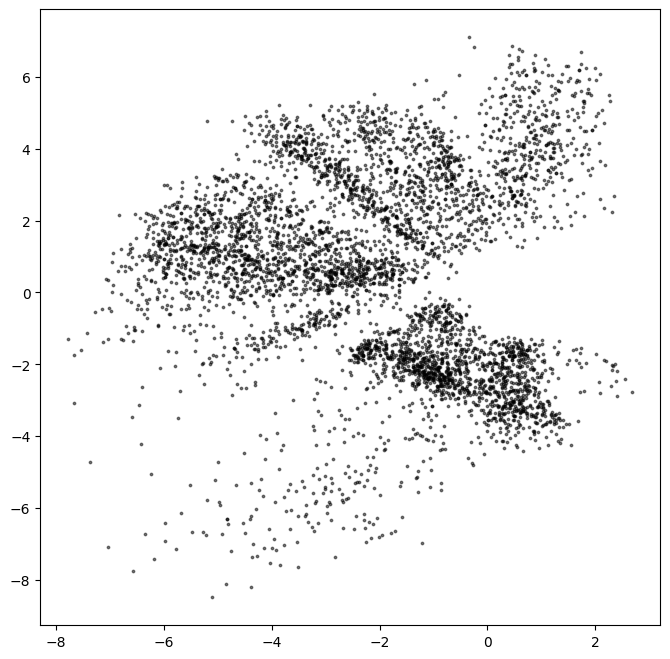

In [17]:
embeddings = encoder.predict(example_images)

plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha=0.5, s=3)
plt.show()

In [28]:
embeddings, embeddings[:, 0], embeddings.shape

(array([[-0.48047262, -1.9073104 ],
        [-5.9626746 ,  1.384332  ],
        [ 0.8765919 ,  6.614893  ],
        ...,
        [-2.509976  , -1.6006501 ],
        [-1.1109731 ,  3.3858962 ],
        [ 0.98581046, -3.175109  ]], dtype=float32),
 array([-0.48047262, -5.9626746 ,  0.8765919 , ..., -2.509976  ,
        -1.1109731 ,  0.98581046], dtype=float32),
 (5000, 2))

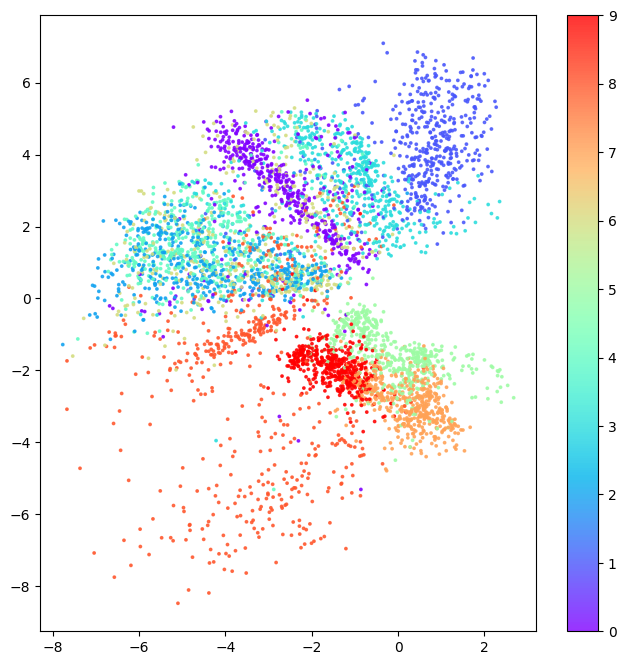

In [31]:
# Colour the embeddings bu their label
example_labels = y_test[:5000]

figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='rainbow',
            c=example_labels, alpha=0.8, s=3)
plt.colorbar()
plt.show()

## Generating New Images

In [41]:
grid_width, grid_height = (6, 3)

In [35]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
mins, maxs

(array([-7.765204, -8.480044], dtype=float32),
 array([2.6791592, 7.098498 ], dtype=float32))

In [39]:
sample = np.random.uniform(mins, maxs, size=(grid_width * grid_height, 2))
sample

array([[ 1.59684582,  1.73812636],
       [-5.84539705, -8.46775832],
       [ 1.00749676,  3.33694657],
       [-0.33531032, -7.00343065],
       [ 1.67872564, -5.8439428 ],
       [ 0.40398714, -4.08766942],
       [-5.93451095,  4.02335751],
       [-0.55942293, -6.64632797],
       [-3.97264941, -0.15983768],
       [ 1.83942998,  4.44658486],
       [-7.30215909, -5.1649464 ],
       [-0.16016096, -2.52391928],
       [-6.11101208,  7.03232861],
       [-1.21127024, -2.15754829],
       [ 0.7150376 , -3.43794991],
       [ 2.3345335 ,  7.05016901],
       [ 1.03528192,  6.80120406],
       [-5.56384941,  4.32285363]])

In [40]:
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 95ms/step


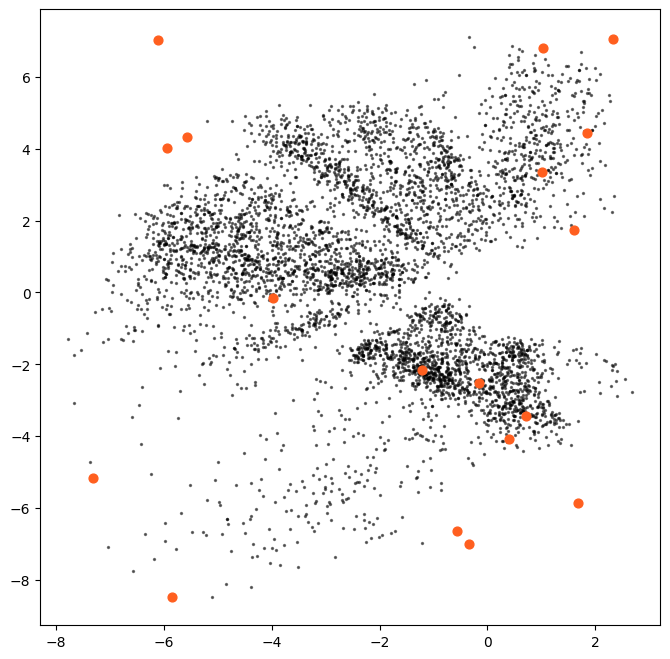

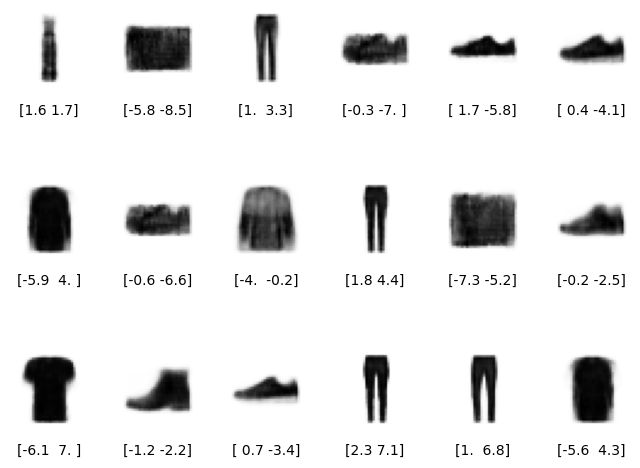

In [43]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

# Original Embeddings
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha=0.5, s=2)

# Newly Generated Points
plt.scatter(sample[:, 0], sample[:, 1], c='#FF5F1F', alpha=1, s=40)

plt.show()

# Add underneath a grid of the decoder images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(sample[i, :], 1)), fontsize=10,
            ha='center', transform=ax.transAxes)
    ax.imshow(reconstructions[i, :, :], cmap='Greys')

8/8 [==============================] - 1s 83ms/step


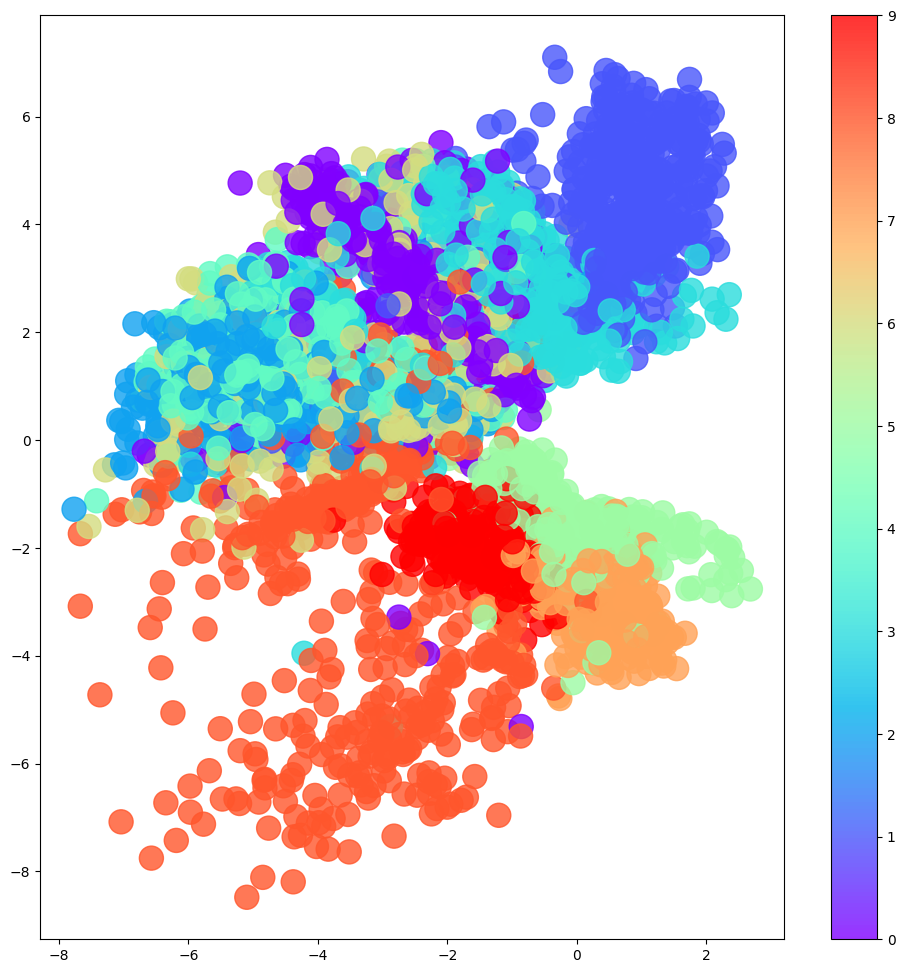

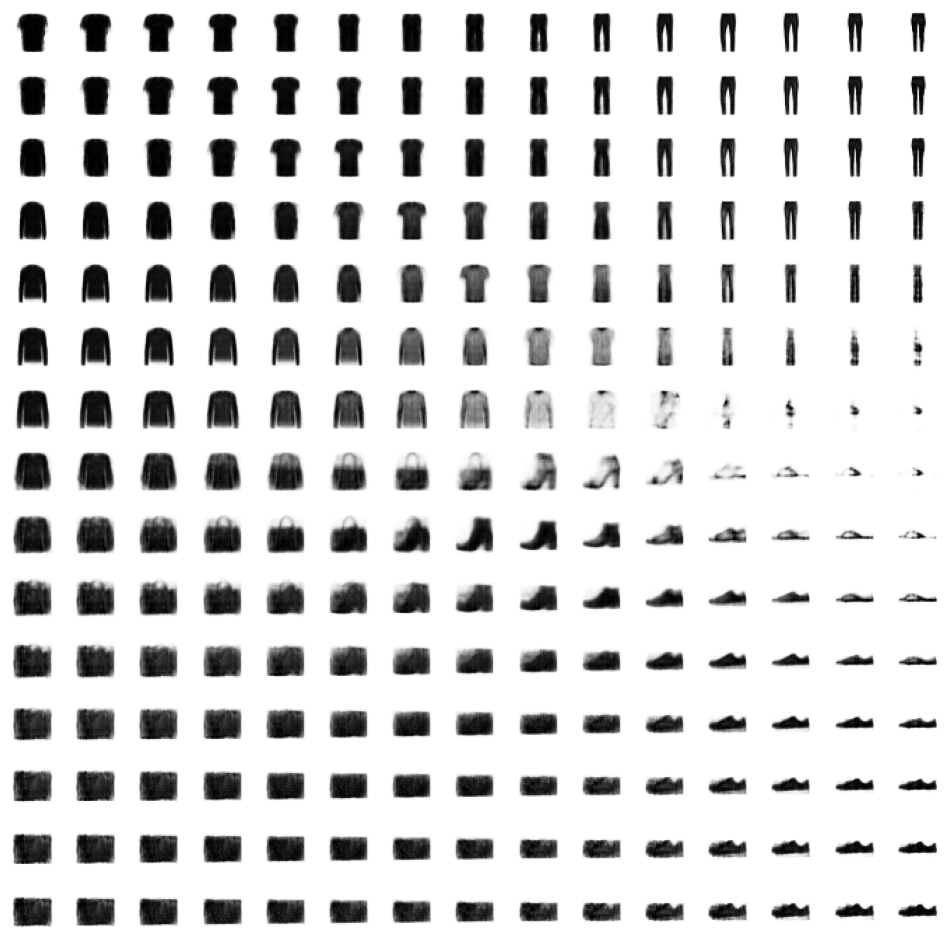

In [44]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")